<a href="https://colab.research.google.com/github/vivihengww/ThinkStats2/blob/master/hackathon_test_ww.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/Charitable-Analytics-International/AI4Good---Meza-OCR-Challenge

fatal: destination path 'AI4Good---Meza-OCR-Challenge' already exists and is not an empty directory.


Testing, is it working

In [0]:
!git clone https://github.com/colaprograms/2019-hackathon-ocr-wymbah

Cloning into '2019-hackathon-ocr-wymbah'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 1), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [0]:
import os, torch, re, sys
import numpy as np
import matplotlib.pyplot as p
import random, PIL

In [0]:
#from google.colab import drive
#drive.mount("/content/gdrive")
#PATH = "/content/gdrive/My Drive/code/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
TRAINING_PATH = "/content/AI4Good---Meza-OCR-Challenge"

def my(*f):
  return os.path.join(PATH, *f)
def data_file(*f):
  return os.path.join(TRAINING_PATH, "cell_images", *f)
def train_file(*f):
  return data_file("training_set", *f)
def valid_file(*f):
  return data_file("validation_set", *f)

def parse(*filename):
  f = open(data_file(*filename))
  first = True
  line = next(f)
  assert line == "filename;value\n"
  out = {}
  for line in f:
    filename, value = line.strip().split(";")
    out[filename] = value
    if not re.match(r"-?[0-9]*[.,]?[0-9]*", value):
      print("bad value:", value)
      raise Exception()
  return out

training = parse("training_set_values.txt")
validate = parse("validation_set_values.txt")

In [0]:
train_items = list(training.items())

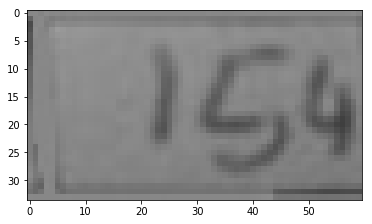

In [0]:
filename, val = random.choice(train_items)

def to_buffer(filename):
  i = PIL.Image.open(filename)
  a = np.array(i.getdata())
  return a.reshape((i.size[1], i.size[0], 3)).astype(np.float64) / 255

def clip(buf):
  grayscale = np.sum(buf, axis=2)
  flat = grayscale.reshape(-1).sort()

image = to_buffer(train_file(filename))

p.imshow(image)
p.show()

In [0]:
# Model

In [0]:
'''
ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385

source: https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
'''


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes,
                               planes,
                               kernel_size=3,
                               stride=stride,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes,
                               planes,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes,
                          self.expansion * planes,
                          kernel_size=1,
                          stride=stride,
                          bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes,
                               planes,
                               kernel_size=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes,
                               planes,
                               kernel_size=3,
                               stride=stride,
                               padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes,
                               self.expansion * planes,
                               kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes,
                          self.expansion * planes,
                          kernel_size=1,
                          stride=stride,
                          bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=7):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self._d_length = nn.Linear(512 * block.expansion, num_classes)
        self._d1 = nn.Linear(512 * block.expansion, 10)
        self._d2 = nn.Linear(512 * block.expansion, 10)
        self._d3 = nn.Linear(512 * block.expansion, 10)
        self._d4 = nn.Linear(512 * block.expansion, 10)
        self._d5 = nn.Linear(512 * block.expansion, 10)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        length_logits, digits_logits = self._d_length(out), [self._d1(out),
                                                             self._d2(out),
                                                             self._d3(out),
                                                             self._d4(out),
                                                             self._d5(out)]
        return length_logits, digits_logits


def ResNet18(num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)


def ResNet34(num_classes):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)


def ResNet50(num_classes):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)


def ResNet101(num_classes):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes)


def ResNet152(num_classes):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes)
